In [1]:

from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import xgboost as xgb
import gc
import sys
import os
sys.path.append(os.path.abspath("../../.."))


from Preprocessing.preprocessing_pipeline_impute import preprocessing_pipeline
from Preprocessing.imputation import get_imputation_maps, apply_imputation,ContextImputer
from Preprocessing.preprocessing_pipeline_segment import preprocessing_pipeline_segment
from Preprocessing.get_all_data import get_full_data
from Preprocessing.split_new import split_data
from utils.eval_call import evaluate_model
from utils.scatter_plot import scatter_prediction

In [2]:
X_train, X_test, y_train, y_test, categorical_features , numeric_features = split_data('../../../data.csv')

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


xgb_pipeline = Pipeline([
    ('imp_fc', ContextImputer('fuel_consumption_l_100km')),
    ('imp_ps', ContextImputer('power_ps')),
    ('imp_er', ContextImputer('electric_range')),
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

# Cross Validation – KFold mit Shuffle und Seed
kf = KFold(n_splits= 10, shuffle=True, random_state=42)
y_pred = cross_val_predict(xgb_pipeline, X_train, y_train, cv=kf)

# Evaluation
print('Cross Validation Training:')
print("MAE:", round(mean_absolute_error(y_train, y_pred),2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_train, y_pred)),2))
print("R²:", round(r2_score(y_train, y_pred),2))

    # Modell trainieren
xgb_pipeline.fit(X_train, y_train)

# Vorhersagen treffen
y_pred_xgb = xgb_pipeline.predict(X_test)

evaluate_model(y_test, y_pred_xgb, "Xgb Boost")


Cross Validation Training:
MAE: 4116.41
RMSE: 14240.17
R²: 0.83
Xgb Boost Performance Metrics:
MAE: 4198.23
MAPE: 20.66
RMSE: 25896.20
R²: 0.68
------------------------------


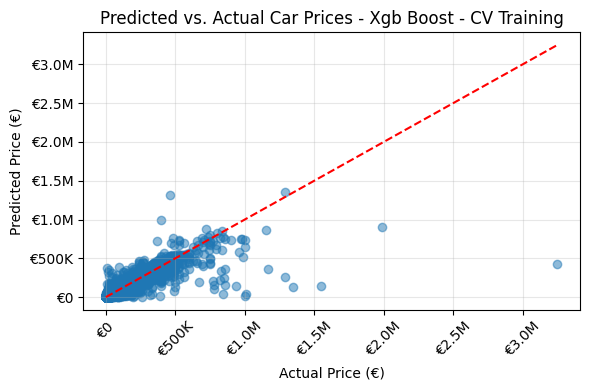

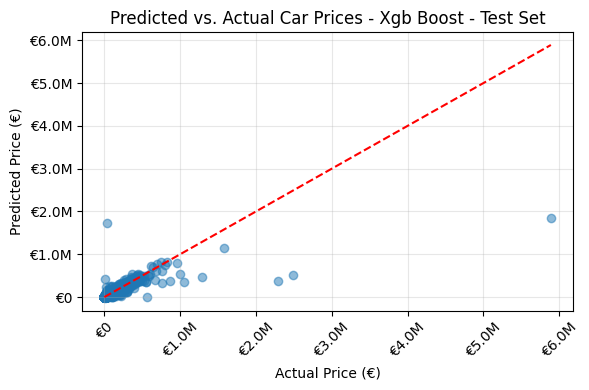

In [3]:
scatter_prediction(y_train, y_pred, "Xgb Boost - CV Training")
scatter_prediction(y_test, y_pred_xgb, "Xgb Boost - Test Set")

### EDA

In [4]:
import pandas as pd

In [5]:
segment_df = pd.read_csv("../../../df_mit_segment.csv")
X_train = X_train.merge(segment_df, on=["brand", "model"], how="left")
X_test = X_test.merge(segment_df, on=["brand", "model"], how="left")

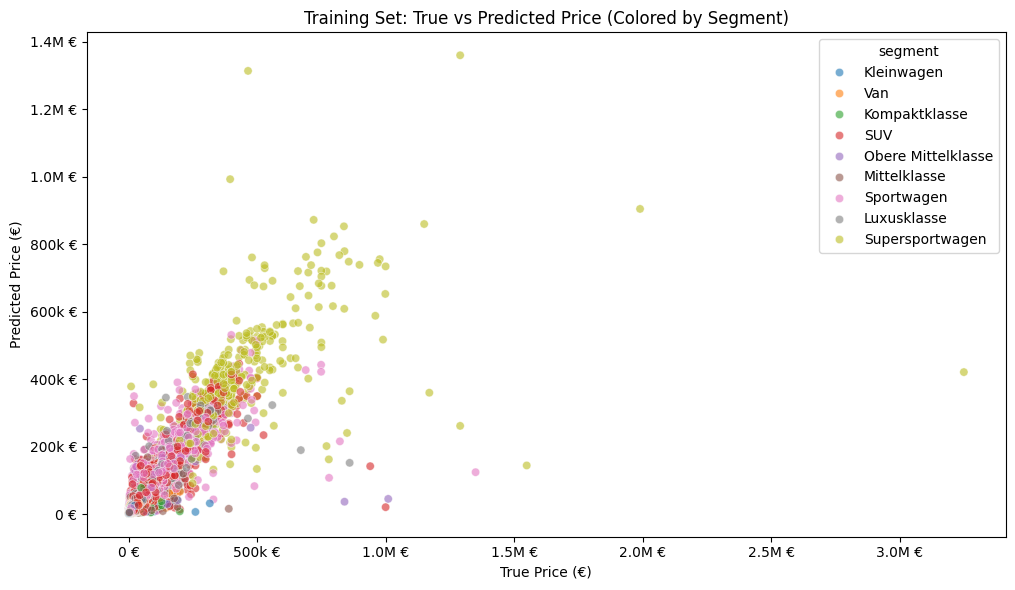

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train, y=y_pred, hue=X_train['segment'], palette='tab10', alpha=0.6, legend='full')
plt.xlabel("True Price (€)")
plt.ylabel("Predicted Price (€)")
plt.title("Training Set: True vs Predicted Price (Colored by Segment)")
plt.tight_layout()

def thousands_formatter(x, pos):
    if abs(x) >= 1_000_000:
        return f"{x/1_000_000:.1f}M €"
    elif abs(x) >= 1_000:
        return f"{x/1_000:.0f}k €"
    else:
        return f"{int(x)} €"

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
plt.show()

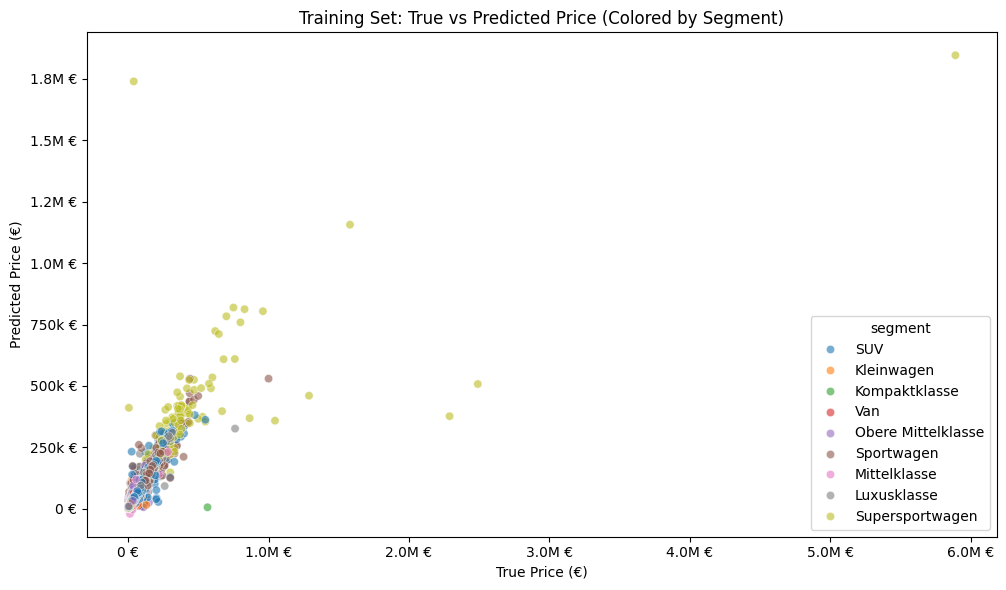

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
import seaborn as sns



plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, hue=X_test['segment'], palette='tab10', alpha=0.6, legend='full')
plt.xlabel("True Price (€)")
plt.ylabel("Predicted Price (€)")
plt.title("Training Set: True vs Predicted Price (Colored by Segment)")
plt.tight_layout()

def thousands_formatter(x, pos):
    if abs(x) >= 1_000_000:
        return f"{x/1_000_000:.1f}M €"
    elif abs(x) >= 1_000:
        return f"{x/1_000:.0f}k €"
    else:
        return f"{int(x)} €"

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
plt.show()

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

segment_metrics = []
for segment in X_test['segment'].unique():
    idx = X_test['segment'] == segment
    y_true = y_test[idx]
    y_pred_seg = y_pred_xgb[idx]
    mae = round(mean_absolute_error(y_true, y_pred_seg),2)
    rmse = round(np.sqrt(mean_squared_error(y_true, y_pred_seg)),2)
    mape = round(mean_absolute_percentage_error(y_true, y_pred_seg),2)
    segment_metrics.append({
        'segment': segment,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    })

segment_metrics_df = pd.DataFrame(segment_metrics)
print(segment_metrics_df.sort_values(by = 'MAPE'))

              segment        MAE       RMSE   MAPE
0                 SUV    4585.65    9106.06  14.19
2       Kompaktklasse    2616.93    6920.81  20.11
1          Kleinwagen    2214.59    3935.54  20.57
3                 Van    3993.03    6630.43  23.03
5          Sportwagen    9590.30   20858.64  23.60
4  Obere Mittelklasse    4531.62    8056.13  25.70
6        Mittelklasse    3254.15    5664.83  27.39
7         Luxusklasse   13401.96   26743.62  31.67
8     Supersportwagen  119133.40  432121.00  90.19


In [9]:
segment_df

,brand,model,segment
0,alfa-romeo,Alfa Romeo GTV,Sportwagen
1,alfa-romeo,Alfa Romeo 164,Obere Mittelklasse
2,alfa-romeo,Alfa Romeo Spider,Sportwagen
3,alfa-romeo,Alfa Romeo 145,Kompaktklasse
4,alfa-romeo,Alfa Romeo 155,Mittelklasse
...,...,...,...
1307,volvo,Volvo S90,Obere Mittelklasse
1308,volvo,Volvo V90 Cross Country,Obere Mittelklasse
1309,volvo,Volvo XC40,SUV
1310,volvo,Volvo C40,SUV
